# The same but better
## How to Eat a Crab, again

Everyone talks about it, everyone does it, everyone thinks they know why they do it, but does anyone really understand the power of different data preprocessing?

If you watch a tutorial or read a book or even poke around with data modelling and analysis, you will eventually (hopefully), come across the *recognised need* to perform some form of preprocessing on your data. You may be having trouble just looking at it (hopefully not because it is a pile of shit) and need to alter it for better presentation. When trying to model or understand patterns and relationships, you may need to smooth, or cut, slice, bend, permute, impute or just mangle into that square hole you have until something feels right, generally our *gut feel* for what it *should be*.

So before you zone out reading this material, let's jump into an example of why we would want to preprocess our data.

In [1]:
# Some imports to get us active
from utils.tools import *

### Some crazy data to get started

Let's go with some crazy data of the daily total inbound tonnes to the shipping terminals in Newcastle, NSW for the entire Hunter Valley Coal Chain.

In [2]:
dfInbound_tonnes = pd.read_pickle('data/inbound_tonnes2010010120201101.pkl')
dfInbound_tonnes.head()

,total_actualtonnes,plannedreceivals,totalactualcycles,Totalplannedcycles,delta
date,,,,,
2016-01-01,501223,542116,60,64,0.0
2016-01-02,414366,471262,50,56,-86857.0
2016-01-03,356261,401661,44,49,-58105.0
2016-01-04,459762,463961,56,56,103501.0
2016-01-05,344504,462463,43,57,-115258.0


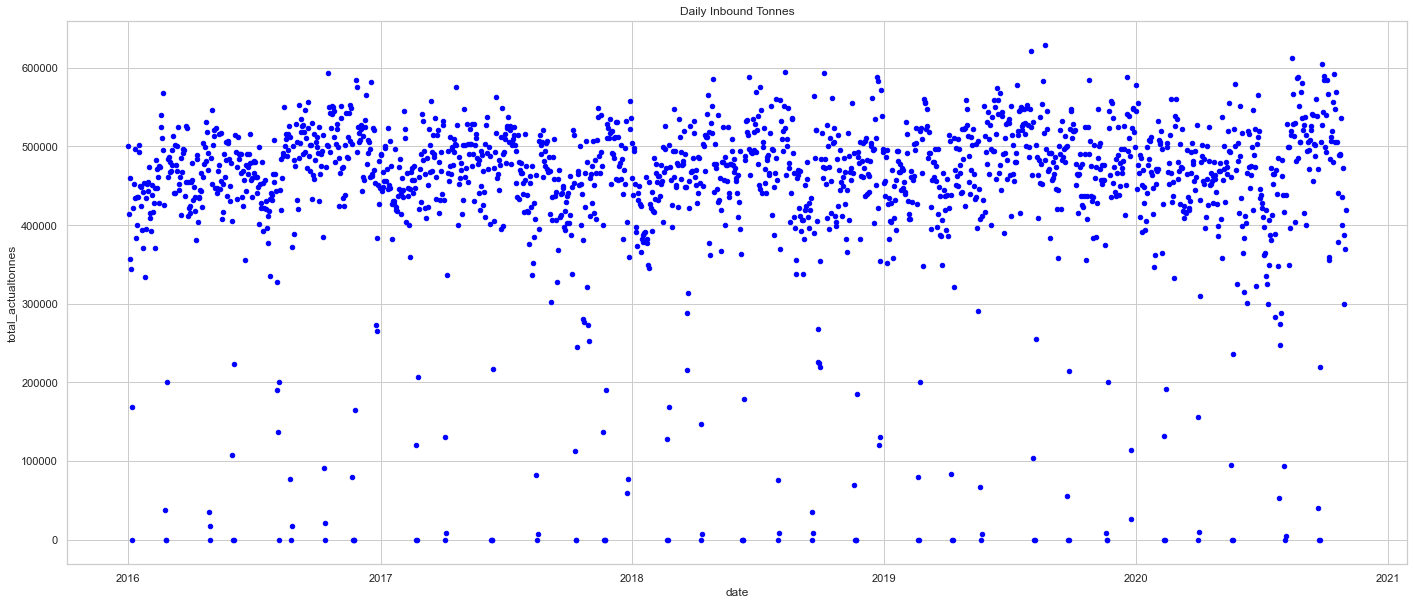

In [4]:
dfInbound_tonnes.reset_index().plot(x='date',y='total_actualtonnes',kind='scatter',figsize=(24,10),color='blue',title='Daily Inbound Tonnes', ylabel='Tonnes')

This data is horrible, from the scatter plot it seems to be a constant value with alot of noise and sprinkles between the constant value and zero. If you squint really hard, there appears to be some undulations at the top of the noise band and possibly more. Who can see what? this should be a warshak test and then we could apply the butterfly or flower filter to clearly see the underlying details.

Suffice to say, even on a good day, i don't see much other than a $y = constant + noise$ relationship. So what can we do? and believe me, this data is not synthetic, this is the real dealio.<br>
> welcome, to the real world ![The real world](img/real-world.jpg)

Let's get rolling, what is that mystical straight line I think I see, it's defintely above 300,000, so let's cut it's legs off and take an average, we'll collect the standard deviation while we're at it, as it's always helpful to understand the amount of spread when we reduce thousand's of data points to a single number with no further context. For example, the average of my salary and Bill Gates becomes unhinged if we don't also get the standard deviation for context.

In [5]:
actual_tonnes_300k = dfInbound_tonnes.loc[dfInbound_tonnes.total_actualtonnes > 300000]
constant, stdval = actual_tonnes_300k.total_actualtonnes.mean(),actual_tonnes_300k.total_actualtonnes.std()
constant, stdval

(471502.0024554942, 51089.57993670853)

Technically we've done some preprocessing already, by removing the values under 300,000 we're applied a simple high pass filter to the data.

Let's see what our first bit of preprocessing on the chart gets us, we might be able to see something bouncing off the mean &#1F92C;  line.

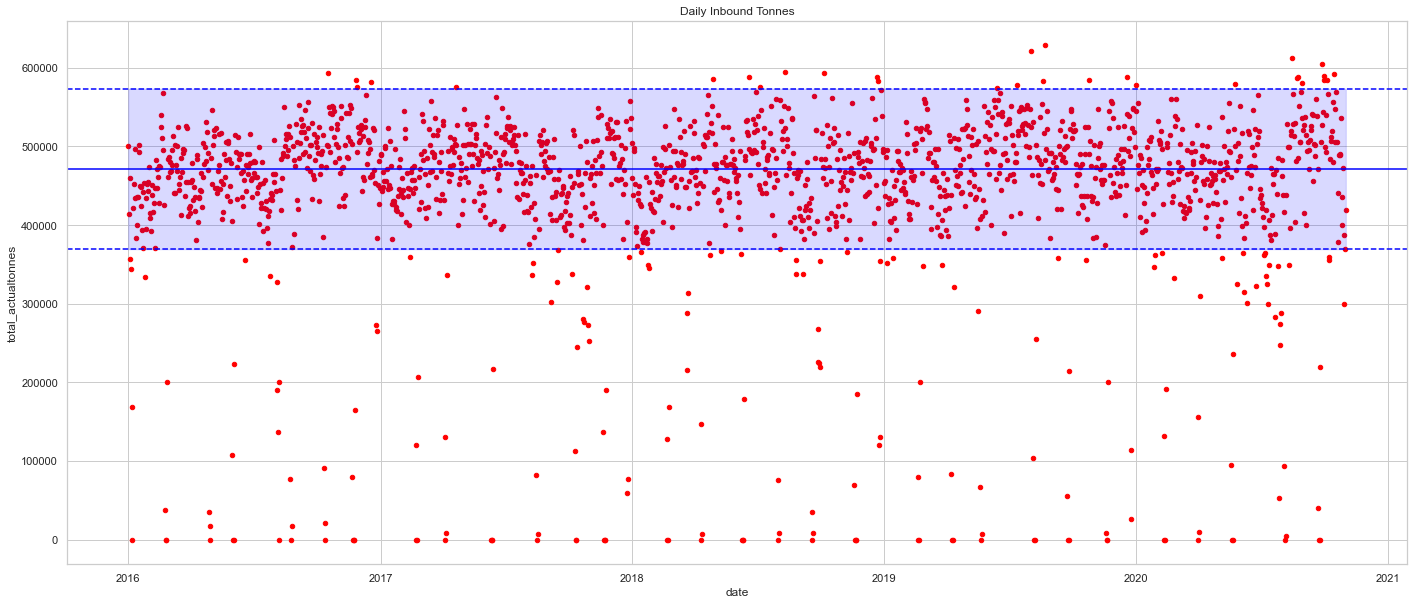

In [6]:
ax = dfInbound_tonnes.reset_index().plot(x='date',y='total_actualtonnes',kind='scatter',figsize=(24,10),color='red',title='Daily Inbound Tonnes', ylabel='Tonnes')
ax.axhline(constant,color='blue')

ax.axhline(constant+2*stdval,color='blue',linestyle='--')
ax.axhline(constant-2*stdval,color='blue',linestyle='--')
ax.fill_between(dfInbound_tonnes.index,constant-2*stdval,constant+2*stdval,color='blue',alpha=0.15)

Now we have some straight lines for reference, with some more squinting, there appears to perhaps be some cyclic movement from the average to the 2 std dev lines. As a quick further check we haven't thrown too much out, we'll cut everything below the lower std dev line and recalculate the average, if it doesn't move too much (say upto 5% of the original value), we can happily cut the remaining values as outliers and move onto looking for more structure inside the band.

In [7]:
actual_tonnes_300k_2sd = dfInbound_tonnes.loc[dfInbound_tonnes.total_actualtonnes > constant-2*stdval]
constant_2sd, stdval_2sd = actual_tonnes_300k_2sd.total_actualtonnes.mean(),actual_tonnes_300k_2sd.total_actualtonnes.std()

print('change from original: {:.2f}%'.format(100.0*(constant-constant_2sd)/constant))
constant_2sd, stdval_2sd

change from original: -0.98%


(476116.84160305344, 45647.88578089671)

About a 1% change, therefore we'll stick with the new filtered dataset and we have completed some preprocessing by filtering out some outliers based on the good'o eye test and some suck it and see descriptive statistics. Now it's time to get a better context of the data bouncing between the upper and lower bands around the average.

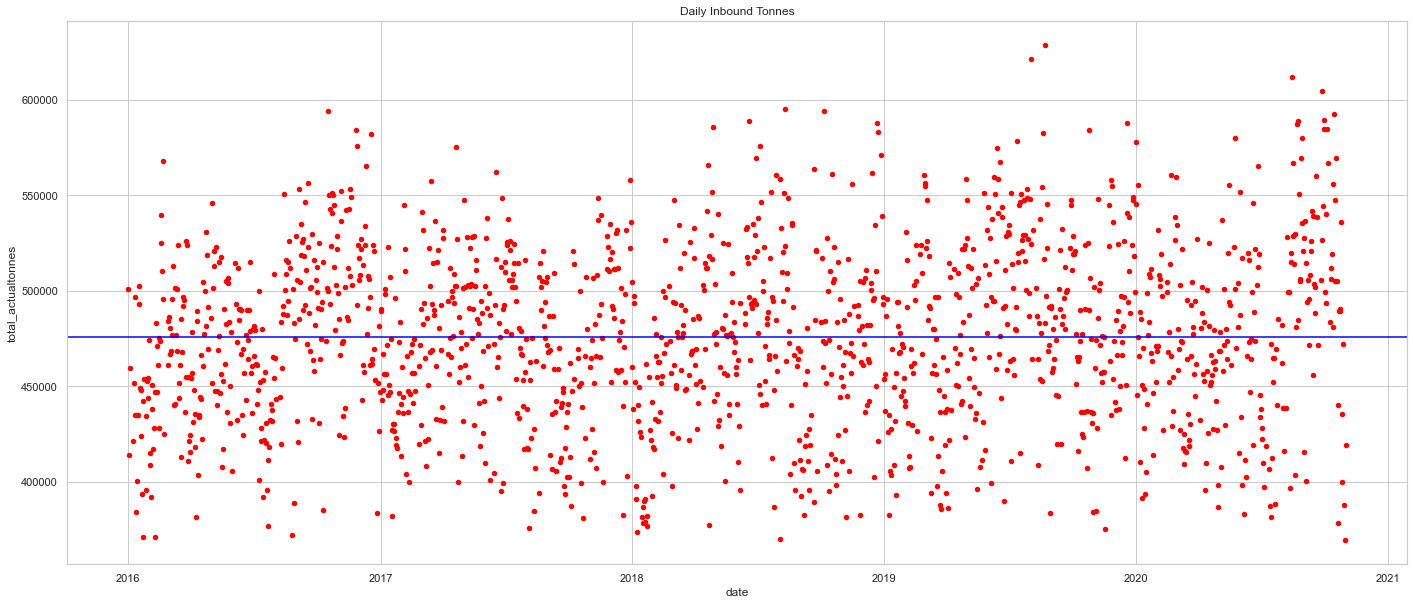

In [8]:
ax = actual_tonnes_300k_2sd.reset_index().plot(x='date',y='total_actualtonnes',kind='scatter',figsize=(24,10),color='red',title='Daily Inbound Tonnes', ylabel='Tonnes')
ax.axhline(constant_2sd,color='blue')

Ok, I'm a bit fan of the laxy programmer ethos, which roughly states that, *"I don't want to write this piece of functionality every again, so do it properly and completely the first time"*. This means if there isn't anything in this data, don't bother looking with a better microscope or sledge hammer, just concede. For our purposes, this means making sure the data isn't;
* Just noise
* [A random walk](https://en.wikipedia.org/wiki/Random_walk)

To check we have only noise, we'll use the quick and dirty and usually reliable, subtract the mean from the dataset and do a historgram of the residals. We can see if by playing with a few distributions from the scipy stats module, if we can get a reasonable match with the histogram. Logically, with our assumption that the data is simply a mean with noise, this implies that each data point could be above the mean or below the mean. There is a perfect distribution for this, $\sigma^2 \sim Beta(\alpha,\beta)$.

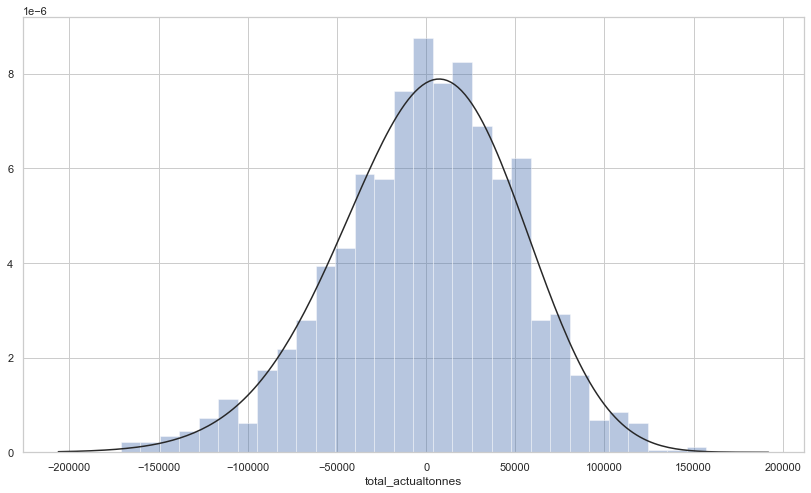

In [9]:
plt.figure(figsize=(14,8))
sns.distplot(actual_tonnes_300k.total_actualtonnes-constant,fit=beta, kde=False)

From this plot and the fit of a Beta distribution, it seems like a good match and therefore another tick in the box for our assumption of the nature of the data and a potential model for it. The main issue is applying a model directly to the data we have seems like it will be a pain in the ass, as even a line through the middle seems to feel shit. Can we get any warm and fuzzy feeling with this data and a model for it? Here comes the trick, blink and you'll miss it, we are going to apply a cummulative sum of the target values, in this case, the total_actualtonnes across the dataset and create a model for this transformed value.

R^2 score: 0.99961
intercept: 992841.54523 and coeff: 434498.88317
EOY Total: 160019432.78570


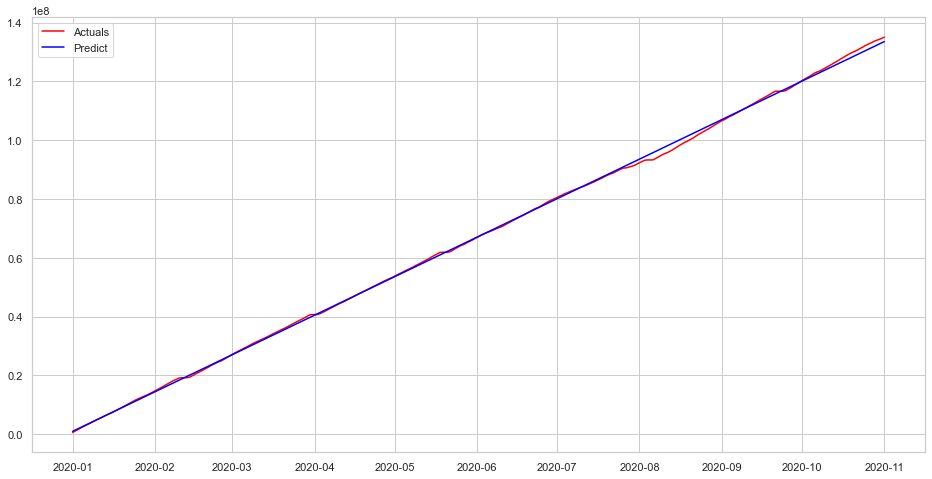

In [22]:
#Filter data to only look at 2020
dfInbound_tonnes_2020 = dfInbound_tonnes.loc[dfInbound_tonnes.index > '31-12-2019']

#Create input and output arrays, best to use the day count from the start instead of actual datetime values
x = (dfInbound_tonnes_2020.index - dfInbound_tonnes_2020.index[0]).days.values.reshape(-1, 1)

#Where the magic transform happens
y = dfInbound_tonnes_2020.total_actualtonnes.cumsum()

#Umm, do I need to explain...
reg = LinearRegression().fit(x, y)

#How did we go and what is our prediction for EOY total
print('R^2 score: {:.5f}'.format(reg.score(x, y)))
print('intercept: {:.5f} and coeff: {:.5f}'.format(reg.intercept_,reg.coef_[0]))
print('EOY Total: {:.5f}'.format((reg.predict([[366]]))[0]))

#Let's see, we all waited for this bit
plt.figure(figsize=(16,8))
plt.plot(dfInbound_tonnes_2020.index,dfInbound_tonnes_2020.total_actualtonnes.cumsum(),color='red',label='Actual')
plt.plot(dfInbound_tonnes_2020.index,reg.predict(x),color='blue',label='Predict')
plt.legend(['Actuals','Predict'])

So we have our fitted regression line that Sklearn went to town on, now we have a formula for the previous as well as future values of the transformed data series that represents the cummulative sum of tonnes up to that date since the start of the data set.

$y(x) =  434498.88\,x + 992841.55$

That's nice, but we wanted the daily value. Now for the human learning instead of the machine learning. This straight line goes up by 434498.88 everytime x increases by 1. What is x? it is the number of days since the start of the data set, so changing x by 1 is how much a single day added to the total since the start of the data set. Umm.....hopefully this has clicked, this is the value for each day. So our answer is that the data is just a constant plus some noise, as per the eye ball test as well as the distribution of the residuals after subtracting the mean.